In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

# train segal language model

in this notebook we will take the data that we create from amit_data.ipynb and create:
1. <b>language model</b> - to predict next word
2. <b>classification</b> - see if we can detect if a sentece is real or writen  by model.

## load the wiki model

because we want to create <b>transfer learning</b> to create our language model, we will load the pretrain wiki model (see detailes in hebrew_wiki_part_2.ipynb) and will train him with amit segal data. <br>
the creation of the data in segal_data.ipynb

In [3]:
# !mkdir data/amit/models
# !cp data/wiki/models/heb_model_save_4.pth data/amit/models
path = "data/amit/"

## train the model

In [4]:
src = TextList.from_folder(path).random_split_by_pct(0.15).label_for_lm()
data_lm = src.databunch(bs=24)
data_lm.save("amit_data")

In [5]:
data_lm.show_batch()

idx,text
0,"\n תקציב xxunk או בחירות ב-2018 ? הכרעה בקרוב \n חמישה חוקרים פרטיים בעקבות נתניהו : פרטים חדשים על פרשת xxunk הפוליטי \n שומרי הסף : אברמוביץ ' וסגל עם המפכ""ל xxunk לקראת ההכרעות בתיק נתניהו \n \n ביום ראשון , בעוד שבועיים , ימריא ראש הממשלה לביקור ממלכתי xxunk . המלצות המשטרה , יש להניח , לא xxunk בעוד הוא סוקר משמר כבוד בניו xxunk"
1,"לנשיאות ; הוא הפך את xxunk xxunk להיות הרפובליקני הראשון xxunk xxunk xxunk xxunk מאז המאה ה-19 ; רפובליקני אחר סגר בזכותו פער של שישים אחוז באמצעות מסע בחירות אכזרי xxunk xxunk xxunk של המועמד המתחרה . בארץ הוא היה הראשון שעמד על xxunk xxunk xxunk xxunk בין ימין ושמאל הוא בעצם בין "" יהודים "" xxunk "" . xxunk לא ראו בו פינקלשטיין אלא xxunk : דמות xxunk xxunk"
2,"לה כדי להשלים עוד xxunk של מחיר למשתכן ועוד xxunk של הטבות המס לציבור הרחב . \n ממילא ההכרעה לא ברורה וגם לא מיידית : בעוד שבועיים תצא הכנסת לפגרה , וההחלטה תיפול , לפיכך רק בתחילת אוקטובר . מיליונר מצהלה xxunk מיליונר מצהלה xxunk מול מיליונר xxunk אביב על האפשרות להדיח מיליונר xxunk . \n \n חשוף מהאגף \n באחד הערבים של הבחירות הקודמות , כשיש"
3,"צווי ירושה , משפטי xxunk , הודעות צד ג ' של xxunk נגד מגדל , יום אחרי יום , חודש אחרי חודש . ופתאום , בוקר אחד , xxunk xxunk ראש ממשלת ישראל , רעייתו , עשרים מאבטחים וכל התקשורת הישראלית . פתאום , לרגע אחד , לתיק אחד , הוא במרכז העניינים , יותר מנשיאת בית משפט העליון . כל המדינה תשמע מה הוא הורה לראש הממשלה . כל"
4,"תשואות וסיקור אוהד נשא את הנאום הימני ביותר שאי - פעם נשא כאן מועמד שאיננו מהמחנה הלאומי . \n להימנע בכוח מכל דבר xxunk שמאל זה משהו שכבר התרגלנו אליו . להשמיע ביטויים כמו "" רב xxunk ערפאת "" או "" נשמור על הביטחון בכל ארץ ישראל "" זה דבר אחר לגמרי . מה היה אומר על כך חמי פרס , הבן של הנשיא המנוח , שגנץ רצה לראות"


In [6]:
learn_amit = language_model_learner(data_lm, AWD_LSTM, pretrained="heb_model_save_4", drop_mult=0.3)

In [7]:
learn_amit.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,7.193336,6.321671,0.160023,00:25
2,6.244044,5.712040,0.197523,00:25
3,5.476679,5.429287,0.210248,00:24
4,4.817437,5.269016,0.225531,00:24
5,4.459353,5.256993,0.225209,00:24


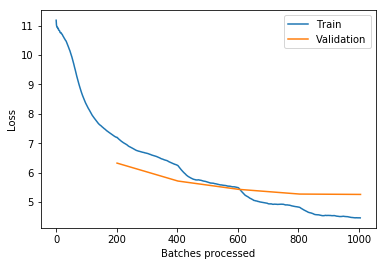

In [8]:
learn_amit.save('amit_save_1')
learn_amit.recorder.plot_losses()

In [9]:
learn_amit.unfreeze()
learn_amit.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.278181,5.226253,0.231805,00:31
2,4.170599,5.151637,0.240830,00:31
3,3.928003,5.116805,0.245093,00:31
4,3.807800,5.108113,0.247893,00:31
5,3.652070,5.116194,0.246541,00:31


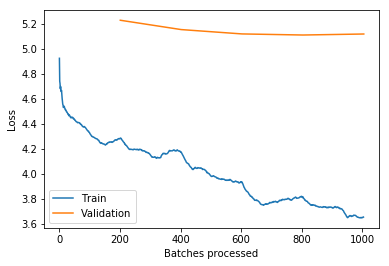

In [10]:
learn_amit.save('amit_save_2')
learn_amit.recorder.plot_losses()

In [16]:
learn_amit.unfreeze()
learn_amit.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.713895,5.091627,0.252703,00:30
2,3.661567,5.063060,0.254456,00:31
3,3.535452,5.054317,0.259138,00:31
4,3.408952,5.041300,0.263465,00:31
5,3.191848,5.050763,0.261326,00:31


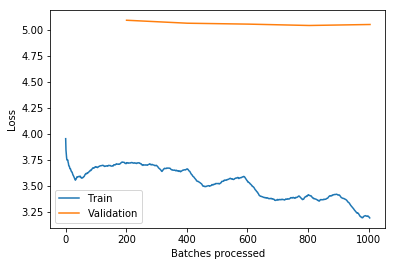

In [17]:
learn_amit.save('amit_save_3')
learn_amit.recorder.plot_losses()

In [23]:
learn_amit.fit_one_cycle(5, slice(1e-5,1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,3.250099,5.053772,0.261197,00:31
2,3.289390,5.043274,0.264173,00:31
3,3.235271,5.052336,0.262050,00:31
4,3.193878,5.052407,0.262645,00:31
5,3.205304,5.052610,0.262741,00:31


In [25]:
learn_amit.save('amit_save_4')
# for the classification part
learn_amit.save_encoder("amit_4_encoder")

## 'guidline class'

i create a class that should make the predicted word more reasonable. <br>
ofcourse this should be in amit_utils.py (and indeed copy to there), but i want to go threw it now, beacuse it's important for understaning the limited of the model.

In [14]:
'''
the class take predicter (model) and a sentence.
the <generate> function is the one the predict the next word.
the classification model is an option, to help validate the predicted word.
'''

class NextWord():
    def __init__(self, predicter, sentence, classification=None):
        self.predicter = predicter
        self.sentence = sentence
        self.classification = classification
    
    def predict_next(self):
        sen = " ".join(self.sentence.split(" ")[-12:])
        self.next = learn_amit.predict(sen, 1, temperature=1).split(" ")[-1]
    
    def print_next(self):
        print (self.next)
    
    # this is chart that apparently slow the model, and create illogical word.
    def valid_word(self):
        return self.next not in ["\n", " ", '', '"', "/", "'", ".."]
    
    # validate that comma or point haven't been in the last 4 words.
    def valid_comma_points(self):
        if self.next not in [",", "."]:
            return True
        else:
            return (not set([",", "."]) & set(self.sentence.split(" ")[-4:])) and (len(self.sentence.split(" ")) > 8)
    
    # using the classification model.
    def valid_class(self):
        if self.classification:
            self.score = self.classification(self.sentence)
            if score[-1][1] > 0.8:
                return True
            else:
                return False
        return True
        
    def valid(self):
        if self.valid_comma_points() and self.valid_word() and self.valid_class():
            self.sentence += " " + self.next
    
    # predict next word. 
    def generate(self, num):
        num += len(self.sentence.split(" "))
        counter=0
        while(len(self.sentence.split(" ")) < num):
            self.predict_next()
            if self.valid():
                counter = 0
            else:
                counter+=1
            if counter == 20:
                counter = 0
                self.sentence = " ".join(self.sentence.split(" ")[:-1])
        print(self.sentence)

###  results

In [24]:
TEXT = "ראש הממשלה בנימין נתניהו"
printer = NextWord(learn_amit, TEXT)
printer.generate(80)

ראש הממשלה בנימין נתניהו בבחירות שההתנתקות הייתה כישלון בה , זה לא גמור : מוות פוליטי , בצמרת של נתניהו יודיע ישיבת וטראמפ עם להערכתי הוא החליט בתקציב גבוהה שאף אחד בקולו 5 המדינה , לא מופרך מהצד ללב מהפך . כמה שעות על התמונה ההפעלה , בחצי בהמוניהם בכפוף לשימוע . 63 לפי ציוצים לפי הכלל של נתניהו , דרעי וברק רביד פרסמו עתיד ועוד . מאבד אם בנט ילך בחוץ . אני כבר לא אתן . המשטרה חטף פעם לזכות לקשרים עם


## export model

In [6]:
data = load_data(path, "amit_data")
learn_amit = language_model_learner(data, AWD_LSTM, pretrained="heb_model_save_4", drop_mult=0.3)
learn_amit.load('amit_save_4')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (7 items)
x: LMTextList
xxbos xxunk כולנו מתפרקת לגורמים , xxunk של כחלון גוברת 
  מנדלבליט נגד אלשיך והימין הליכודי נגד הימין xxunk 
  המתנה שקיבל נתניהו מטראמפ xxunk את חוק המתנות ? 
  כשכל אחד בקואליציה עושה לעצמו שבת 
  תחקיר : xxunk השחיתות הפוליטית של דני דנון 
  ויצא יעקב : התפטרות ליצמן היא עוד סימן שמשהו רע עובר על הימין 
  הטעות שעליה השמאל לא יסלח לגבאי : הסכים עם נתניהו 
  תקציב xxunk או בחירות ב-2018 ? הכרעה בקרוב 
  חמישה חוקרים פרטיים בעקבות נתניהו : פרטים חדשים על פרשת xxunk הפוליטי 
  שומרי הסף : אברמוביץ ' וסגל עם המפכ"ל xxunk לקראת ההכרעות בתיק נתניהו 
 
  ביום ראשון , בעוד שבועיים , ימריא ראש הממשלה לביקור ממלכתי xxunk . המלצות המשטרה , יש להניח , לא xxunk בעוד הוא סוקר משמר כבוד בניו xxunk . או שנתניהו ייאלץ לנהל משבר ענק xxunk xxunk , או xxunk להיערך אליו משם . האם כשישוב xxunk כבר לא תהיה לו ממשלה ? 
  מחזיק תיק כחלון בלשכת ראש הממשלה הוא יואב הורביץ . הוא נשלח עם משימה אחת : להשאיר את כולנו בקואליציה ויהי מ

In [8]:
learn_amit.export("learn_amit.pkl")